In [1]:
import numpy as np
import pandas as pd

## Datos de entrenamiento
En el ficher `apple_news.csv` hay un listado de noticias desde el año `efwefwe` hasta `sdfdgds`. Los datos tienen la siguiente estructura:

- _ticker_: Abreviatura del stock, en este caso **AAPL**
- _Date_: Fecha de la noticia
- _title_: Título de la noticia
- _content_: Contenido de la noticia
- _Open_: Precio de apertura de la acción ese día
- _Close_: Precio de cierre de la acción ese día
- _High_: Máximo precio alcanzado ese día
- _Low_: Mínimo precio alcanzado ese día
- _Volume_: Volumen de transacciones procesada ese día
- _label_: **0** si el precio subió o **1** si cayó o se mantuvo

Los demás datos no sabemos específicamente su significado o directamente no es relevante para nosotros.
Estos datos tienen algunos inconvenientes, por lo que tenemos que hacerle un preprocesamiento antes de continuar.

1. Las fechas están en formato `object`, por lo que hay que convertirlas a fechas para poder usarlas
2. Hay dias en donde no hay noticias y hay otros dias en donde hay mas de una noticia. Para esto lo que haremos será convinar todas las noticias del mismo día y convertirlas en una sola
3. Para los dias que no tiene noticias(ya veremos)

In [6]:
import time
from google.colab import drive

drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/ML_Colab/apple_news.csv'
# Read the CSV file into a Pandas DataFrame
news_df = pd.read_csv(csv_file_path)
news_df['Date'] = pd.to_datetime(news_df['Date'])
news_df['Date'] = news_df['Date'].apply(lambda x: time.strftime('%Y-%m-%d', x.timetuple()))
news_df.set_index('Date', inplace=True)

print('Shape: ', news_df.shape)
news_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (15975, 12)


,Unnamed: 0,ticker,category,title,content,Open,High,Low,Close,Adj Close,Volume,label
Date,,,,,,,,,,,,
2020-01-27,0,AAPL,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
2020-01-27,1,AAPL,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
2020-01-27,2,AAPL,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0


# Analisis de los datos
 Utilizando dew_df.info() podemos ver que no hay valores nulos en las filas del dataset po rlo que no hay valores faltantes
 Las columnas title content ticker y categorie tienen tipo object ; el dataset tiene una combinacion de variables de tipo numericas y categoricas
 tiene una variable Unamed que es el id del elemento , lo que puede generar ruido al entrenar el modelo,


In [7]:
amount_dates = news_df.index.unique()

print('Información básica sobre las noticias: ')
print(f'\tCantidad de noticias: {news_df.shape[0]}')
print(f'\tCantidad de fechas con noticias: {len(amount_dates)}')
print(f'\tNoticias sobrantes: {news_df.shape[0] - len(amount_dates)}')

Información básica sobre las noticias: 
	Cantidad de noticias: 15975
	Cantidad de fechas con noticias: 1654
	Noticias sobrantes: 14321


### Eliminamos las fechas vacias o sin noticias para evitar redundancias en los datos fechas con la misma noticia a diferentes horas , lo cual en definitiva es la misma noticia.

ELiminación de todas las noticias que habían el mismo día y convertirlas todas a una única noticia por día

In [8]:
news_df = news_df.sort_values(by='Date', ascending=False)
news_df['new'] = news_df['title'] + ' ' + news_df['content']
news_df = news_df.groupby('Date').agg({
    'new': ' '.join
}).reset_index()
news_df.set_index('Date', inplace=True)
# Display the combined news DataFrame
print('New Shape: ', news_df.shape)
news_df

New Shape:  (1654, 1)


,new
Date,
2012-07-23,Summer Heat Scorches Europe And U S Europe fl...
2012-07-24,Market Bait And Switch That is the sound we ar...
2012-07-27,Will AAPL Fall From The Tree Apple s AAPL ...
2012-07-30,Bulls Snatch Victory From Jaws of Defeat Last ...
2012-07-31,What s Driving China s Real Estate Rally Par...
...,...
2020-01-21,How to download Apple Card data into a spreads...
2020-01-22,Dow Jones News IBM Reports Strong Results Ap...
2020-01-23,Apple Boosts Chip Orders From Main Foundry Sup...


## Obtenemos un dataset limpio de noticias procesadas


### Procesar la noticias con nlp

Pasamos de tener `15975` noticias a solo quedarnos con `1654`. Ahora vectoricemos las noticias utilizando técnicas de nlp.

In [10]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
  text = text.lower()
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
  return tokens

news_df['processed'] = news_df['new'].apply(preprocess)
news_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,new,processed
Date,,
2012-07-23,Summer Heat Scorches Europe And U S Europe fl...,"[summer, heat, scorches, europe, u, europe, fl..."
2012-07-24,Market Bait And Switch That is the sound we ar...,"[market, bait, switch, sound, going, hear, soo..."
2012-07-27,Will AAPL Fall From The Tree Apple s AAPL ...,"[aapl, fall, tree, apple, aapl, sales, third, ..."
2012-07-30,Bulls Snatch Victory From Jaws of Defeat Last ...,"[bulls, snatch, victory, jaws, defeat, last, w..."
2012-07-31,What s Driving China s Real Estate Rally Par...,"[driving, china, real, estate, rally, part, 3,..."
...,...,...
2020-01-21,How to download Apple Card data into a spreads...,"[download, apple, card, data, spreadsheet, app..."
2020-01-22,Dow Jones News IBM Reports Strong Results Ap...,"[dow, jones, news, ibm, reports, strong, resul..."
2020-01-23,Apple Boosts Chip Orders From Main Foundry Sup...,"[apple, boosts, chip, orders, main, foundry, s..."


In [11]:
# Entrenar el modelo de Word2Vec
model = Word2Vec(
  sentences=news_df['processed'],
  vector_size=100,
  window=5,
  min_count=1,
  workers=40
)

In [12]:
# Función para obtener el embedding promedio de una noticia
def get_average_embedding(tokens, model):
  # Filtrar tokens que están en el vocabulario del modelo
  tokens = [token for token in tokens if token in model.wv]
  if len(tokens) == 0:
    return np.zeros(model.vector_size)
  # Calcular el embedding promedio
  embeddings = [model.wv[token] for token in tokens]
  average_embedding = np.mean(embeddings, axis=0)
  return average_embedding

# Obtener embeddings promedio para cada noticia
news_df['embedding'] = news_df['processed'].apply(lambda tokens: get_average_embedding(tokens, model))
news_df

,new,processed,embedding
Date,,,
2012-07-23,Summer Heat Scorches Europe And U S Europe fl...,"[summer, heat, scorches, europe, u, europe, fl...","[-0.057636242, 0.68624556, 0.5934793, -0.26745..."
2012-07-24,Market Bait And Switch That is the sound we ar...,"[market, bait, switch, sound, going, hear, soo...","[0.12709866, -0.01873347, 0.78530383, -0.73206..."
2012-07-27,Will AAPL Fall From The Tree Apple s AAPL ...,"[aapl, fall, tree, apple, aapl, sales, third, ...","[-0.29023948, 0.3231525, 0.34651077, -0.770759..."
2012-07-30,Bulls Snatch Victory From Jaws of Defeat Last ...,"[bulls, snatch, victory, jaws, defeat, last, w...","[-0.07985627, 0.50908303, 0.65735525, -0.70797..."
2012-07-31,What s Driving China s Real Estate Rally Par...,"[driving, china, real, estate, rally, part, 3,...","[0.14126478, 0.6464847, 0.51183265, -0.5147002..."
...,...,...,...
2020-01-21,How to download Apple Card data into a spreads...,"[download, apple, card, data, spreadsheet, app...","[-0.05702098, 0.6851138, 0.4708476, -0.4604497..."
2020-01-22,Dow Jones News IBM Reports Strong Results Ap...,"[dow, jones, news, ibm, reports, strong, resul...","[-0.023503222, 0.72319293, 0.560967, -0.520783..."
2020-01-23,Apple Boosts Chip Orders From Main Foundry Sup...,"[apple, boosts, chip, orders, main, foundry, s...","[-0.16442153, 0.8229837, 0.50413156, -0.386499..."


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


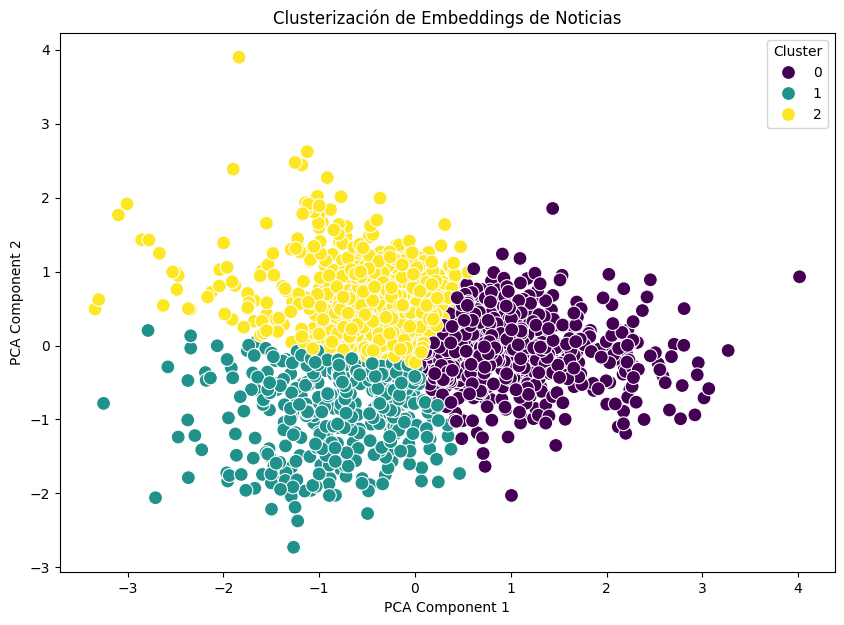

In [13]:
# Clusteriazión de los emeddings
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir la columna de embeddings a una matriz 2D (cada fila es un embedding)
embeddings = np.vstack(news_df['embedding'])

# Reducir la dimensionalidad a 2D usando PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Aplicar KMeans para clusterizar los embeddings
nclusters = 3
kmeans = KMeans(n_clusters=nclusters, random_state=0)
clusters = kmeans.fit_predict(reduced_embeddings)

# Añadir los resultados de PCA y los clusters al DataFrame
news_df['pca_x'] = reduced_embeddings[:, 0]
news_df['pca_y'] = reduced_embeddings[:, 1]
news_df['cluster'] = clusters

# Visualizar los clusters usando un scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=news_df, x='pca_x', y='pca_y', hue='cluster', palette='viridis', s=100)
plt.title('Clusterización de Embeddings de Noticias')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [14]:
news_df.head(1)

,new,processed,embedding,pca_x,pca_y,cluster
Date,,,,,,
2012-07-23,Summer Heat Scorches Europe And U S Europe fl...,"[summer, heat, scorches, europe, u, europe, fl...","[-0.057636242, 0.68624556, 0.5934793, -0.26745...",-1.276798,0.591356,2


In [17]:
# eliminando columnas innecesarias
news_df.drop(columns=['new', 'processed', 'pca_x', 'pca_y', 'cluster'], inplace=True)

In [18]:
news_df.head(1)

,embedding
Date,
2012-07-23,"[-0.057636242, 0.68624556, 0.5934793, -0.26745..."


# PROCESAMIENTO DEL CSV DEL PRECIO DEL STOCK

In [20]:
import pandas as pd
import time
from google.colab import drive

drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/ML_Colab/apple_stock_prices.csv'
# Read the CSV file into a Pandas DataFrame
prices_df = pd.read_csv(csv_file_path)
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df['Date'] = prices_df['Date'].apply(lambda x: time.strftime('%Y-%m-%d', x.timetuple()))
prices_df.set_index('Date', inplace=True)

print('Shape: ', prices_df.shape)
prices_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
prices_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (6165, 7)


,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,0.791669,0.849227,0.767607,0.844981,535796800
2000-01-04,0.817145,0.835073,0.763833,0.773740,512377600
2000-01-05,0.783176,0.834601,0.777515,0.785063,778321600
2000-01-06,0.801105,0.807709,0.717125,0.717125,767972800
2000-01-07,0.728448,0.762417,0.720900,0.751094,460734400
...,...,...,...,...,...
2024-06-28,215.770004,216.070007,210.300003,210.619995,82542700
2024-07-01,212.089996,217.509995,211.919998,216.750000,60402900
2024-07-02,216.149994,220.380005,215.100006,220.270004,58046200


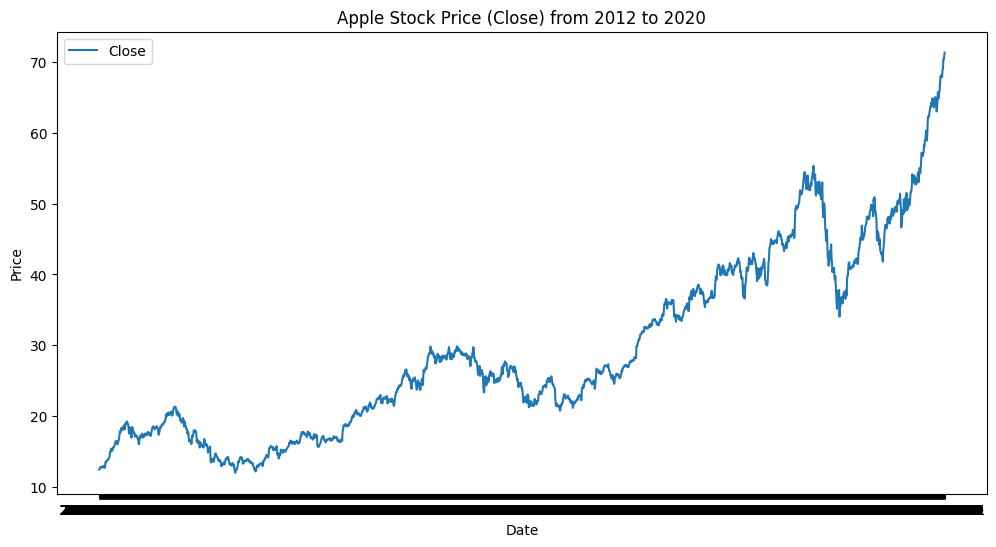

In [21]:
import matplotlib.pyplot as plt

# Select the data from 2017 to 2024
prices_df_subset = prices_df["2012":"2020"]

# Plot the close prices
plt.figure(figsize=(12, 6))
plt.plot(prices_df_subset["Close"], label="Close")
plt.title("Apple Stock Price (Close) from 2012 to 2020")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


El histórico de datos tiene el precio durante varios años atrás pero no tiene datos los fines de semana debido a que la bolsa de valores no está abierta esos días. Lo que haremos entonces será insertar nuevos datos en esos fines de semanas y mantener el mismo precio del día anterior ya que no hubo operaciones y el volumen ponerlo en cero

In [22]:
# Comprobar la cantidad de fechas que tienen noticias pero que no tienen precio
missing_dates = set(news_df.index) - set(prices_df.index)
print(f"Number of dates in news_df that are not in prices_df: {len(missing_dates)}")
missing_dates

Number of dates in news_df that are not in prices_df: 123


{'2012-11-10',
 '2012-12-09',
 '2013-02-10',
 '2013-05-12',
 '2013-06-02',
 '2013-08-04',
 '2013-08-11',
 '2013-10-06',
 '2013-11-09',
 '2013-12-08',
 '2014-01-04',
 '2014-01-05',
 '2014-01-12',
 '2014-02-09',
 '2014-05-11',
 '2014-06-01',
 '2014-06-08',
 '2014-07-04',
 '2014-09-01',
 '2014-09-07',
 '2014-10-12',
 '2014-11-02',
 '2014-11-08',
 '2014-11-09',
 '2015-01-04',
 '2015-02-01',
 '2015-02-07',
 '2015-03-08',
 '2015-04-03',
 '2015-04-05',
 '2015-04-11',
 '2015-04-12',
 '2015-05-03',
 '2015-05-10',
 '2015-06-07',
 '2015-07-05',
 '2015-07-12',
 '2015-08-09',
 '2015-09-06',
 '2015-10-04',
 '2015-10-11',
 '2015-11-08',
 '2015-12-06',
 '2016-01-03',
 '2016-02-06',
 '2016-03-05',
 '2016-04-02',
 '2016-04-03',
 '2016-04-10',
 '2016-05-01',
 '2016-05-08',
 '2016-06-05',
 '2016-06-12',
 '2016-07-03',
 '2016-07-04',
 '2016-07-10',
 '2016-08-07',
 '2016-09-03',
 '2016-09-05',
 '2016-09-11',
 '2016-10-02',
 '2017-01-02',
 '2017-01-08',
 '2017-02-05',
 '2017-03-05',
 '2017-04-08',
 '2017-05-

In [23]:
# eliminar por ahora estos días de news_df
news_df.drop(missing_dates, inplace=True)
# Comprobar la cantidad de fechas que tienen noticias pero que no tienen precio
missing_dates = set(news_df.index) - set(prices_df.index)
print(f"Number of dates in news_df that are not in prices_df: {len(missing_dates)}")
missing_dates

Number of dates in news_df that are not in prices_df: 0


set()

In [24]:
# combinar los dos dataframes por Date
merged_df = prices_df.combine_first(news_df)
merged_df

,Close,High,Low,Open,Volume,embedding
Date,,,,,,
2000-01-03,0.844981,0.849227,0.767607,0.791669,535796800,NaN
2000-01-04,0.773740,0.835073,0.763833,0.817145,512377600,NaN
2000-01-05,0.785063,0.834601,0.777515,0.783176,778321600,NaN
2000-01-06,0.717125,0.807709,0.717125,0.801105,767972800,NaN
2000-01-07,0.751094,0.762417,0.720900,0.728448,460734400,NaN
...,...,...,...,...,...,...
2024-06-28,210.619995,216.070007,210.300003,215.770004,82542700,NaN
2024-07-01,216.750000,217.509995,211.919998,212.089996,60402900,NaN
2024-07-02,220.270004,220.380005,215.100006,216.149994,58046200,NaN


In [26]:
embedding_size = news_df['embedding'][0].size
merged_df['embedding'] = merged_df['embedding'].apply(lambda x: np.zeros(embedding_size) if pd.isna(x) is True else x)
merged_df

,Close,High,Low,Open,Volume,embedding
Date,,,,,,
2000-01-03,0.844981,0.849227,0.767607,0.791669,535796800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2000-01-04,0.773740,0.835073,0.763833,0.817145,512377600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2000-01-05,0.785063,0.834601,0.777515,0.783176,778321600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2000-01-06,0.717125,0.807709,0.717125,0.801105,767972800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2000-01-07,0.751094,0.762417,0.720900,0.728448,460734400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
2024-06-28,210.619995,216.070007,210.300003,215.770004,82542700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2024-07-01,216.750000,217.509995,211.919998,212.089996,60402900,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2024-07-02,220.270004,220.380005,215.100006,216.149994,58046200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Datos extras que nos servirán
Ademas de tener el histórico de precios, el volumen manejado por cada día y el embedding de las noticias, es interesante añadir algunos indicadores técnicos que se usan para hacer análisis técnico en el trading y encontrar patrones. Estaremos usando 3 Indicadores:
1. EMA50 (Media movil exponencial de 50 periodos)
2. EMA200 (Media movil exponencial de 200 periodos)

In [28]:
%%capture

# Primero, instalar las dependencias necesarias
!apt-get install -y libzzip-dev libcurl4-openssl-dev

# Descargar e instalar TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install

# Finalmente, instalar la librería de Python
!pip install TA-Lib

In [35]:
# Calcular indicadores técnicos
import talib

# Media Móvil Simple (SMA)
merged_df['SMA_200'] = talib.SMA(merged_df['Close'], timeperiod=200)

# Media Móvil Exponencial (EMA)
merged_df['EMA_50'] = talib.EMA(merged_df['Close'], timeperiod=50)

# fill the first positions in SMA_200 and EMA_500 with zero
merged_df['SMA_200'] = merged_df['SMA_200'].fillna(method='bfill')
merged_df['EMA_50'] = merged_df['EMA_50'].fillna(method='bfill')

merged_df

,Close,High,Low,Open,Volume,embedding,SMA_200,EMA_50
Date,,,,,,,,
2000-01-03,0.844981,0.849227,0.767607,0.791669,535796800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.799947,0.835547
2000-01-04,0.773740,0.835073,0.763833,0.817145,512377600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.799947,0.835547
2000-01-05,0.785063,0.834601,0.777515,0.783176,778321600,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.799947,0.835547
2000-01-06,0.717125,0.807709,0.717125,0.801105,767972800,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.799947,0.835547
2000-01-07,0.751094,0.762417,0.720900,0.728448,460734400,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.799947,0.835547
...,...,...,...,...,...,...,...,...
2024-06-28,210.619995,216.070007,210.300003,215.770004,82542700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",183.323794,195.344996
2024-07-01,216.750000,217.509995,211.919998,212.089996,60402900,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",183.539925,196.184407
2024-07-02,220.270004,220.380005,215.100006,216.149994,58046200,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",183.766037,197.128941


In [36]:
merged_df.to_csv('/content/drive/My Drive/ML_Colab/merged_apple_price_news.csv')

# Analisis exploratorio de datos
todos los datos son numericos y no hay datos faltantes


In [57]:
import pandas as pd
import time
from google.colab import drive

drive.mount('/content/drive')
csv_file_path = '/content/drive/My Drive/ML_Colab/apple_stock_prices.csv'
# Read the CSV file into a Pandas DataFrame
prices_df = pd.read_csv(csv_file_path)
prices_df['Date'] = pd.to_datetime(prices_df['Date'])
prices_df['Date'] = prices_df['Date'].apply(lambda x: time.strftime('%Y-%m-%d', x.timetuple()))
prices_df.set_index('Date', inplace=True)

print('Shape: ', prices_df.shape)
prices_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape:  (6165, 7)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,0.791669,0.849227,0.767607,0.844981,535796800,0.0,0.0
2000-01-04,0.817145,0.835073,0.763833,0.773740,512377600,0.0,0.0
2000-01-05,0.783176,0.834601,0.777515,0.785063,778321600,0.0,0.0
2000-01-06,0.801105,0.807709,0.717125,0.717125,767972800,0.0,0.0
2000-01-07,0.728448,0.762417,0.720900,0.751094,460734400,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-28,215.770004,216.070007,210.300003,210.619995,82542700,0.0,0.0
2024-07-01,212.089996,217.509995,211.919998,216.750000,60402900,0.0,0.0
2024-07-02,216.149994,220.380005,215.100006,220.270004,58046200,0.0,0.0


In [58]:
cat_cols=prices_df.select_dtypes(include=['object']).columns
num_cols = prices_df.select_dtypes(include=np.number).columns.tolist()
print("Categorical Variables:")
print(cat_cols)
print("Numerical Variables:")
print(num_cols)

Categorical Variables:
Index([], dtype='object')
Numerical Variables:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']


Open
Skew : 1.65


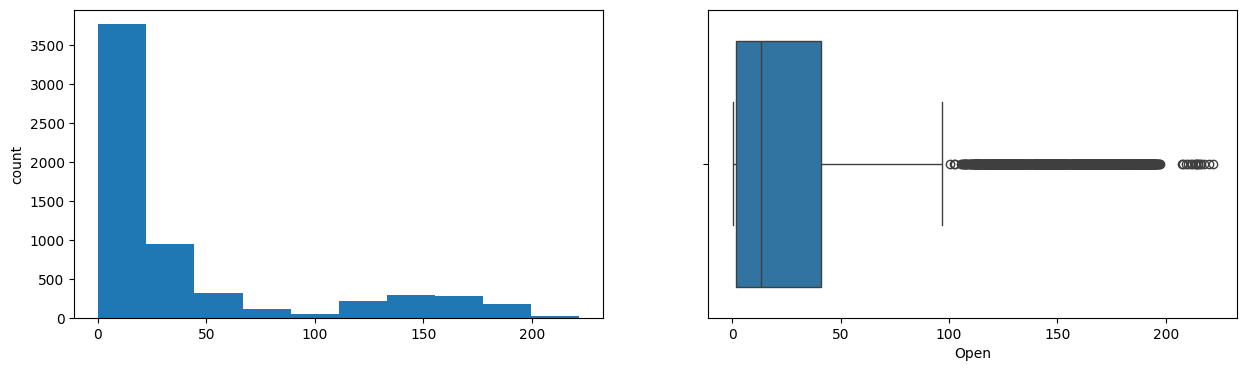

High
Skew : 1.65


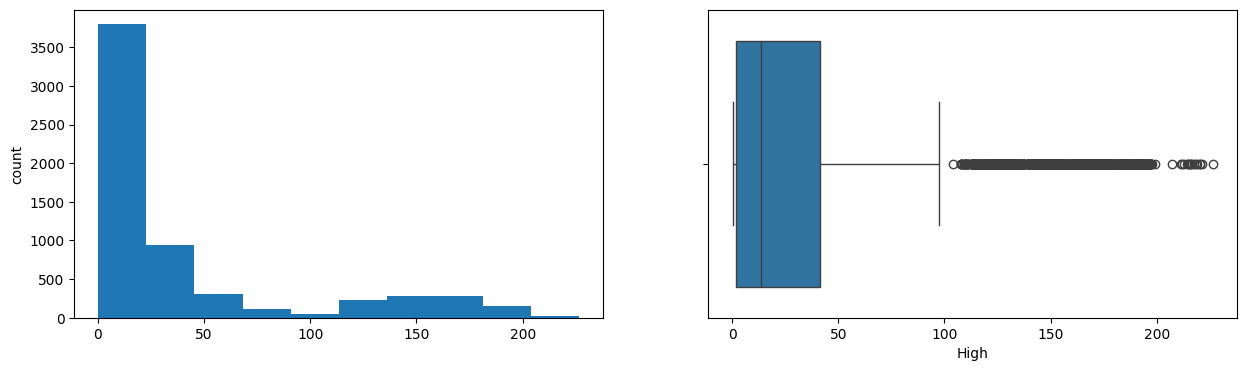

Low
Skew : 1.66


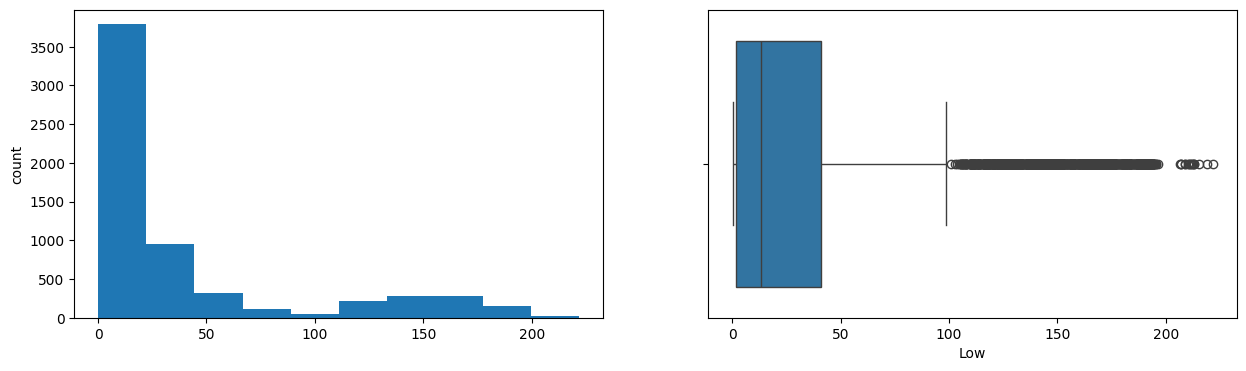

Close
Skew : 1.65


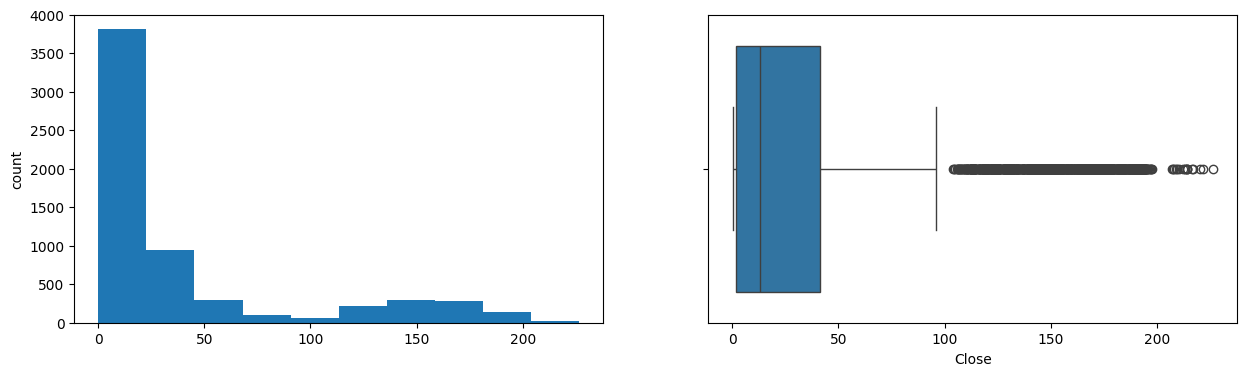

Volume
Skew : 2.97


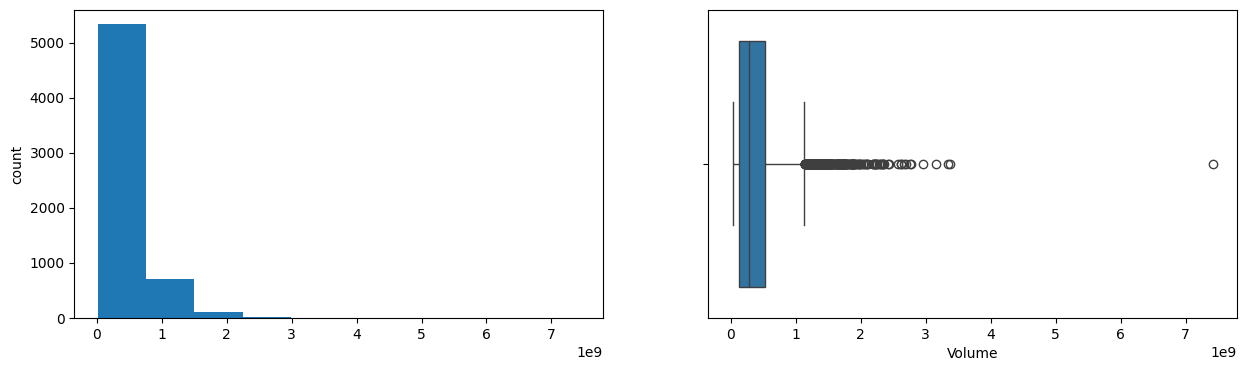

Dividends
Skew : 12.37


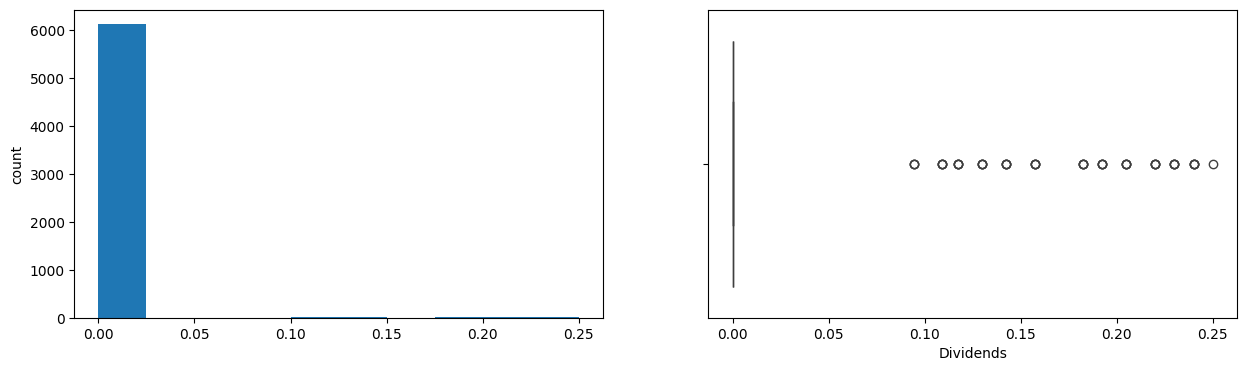

Stock Splits
Skew : 53.24


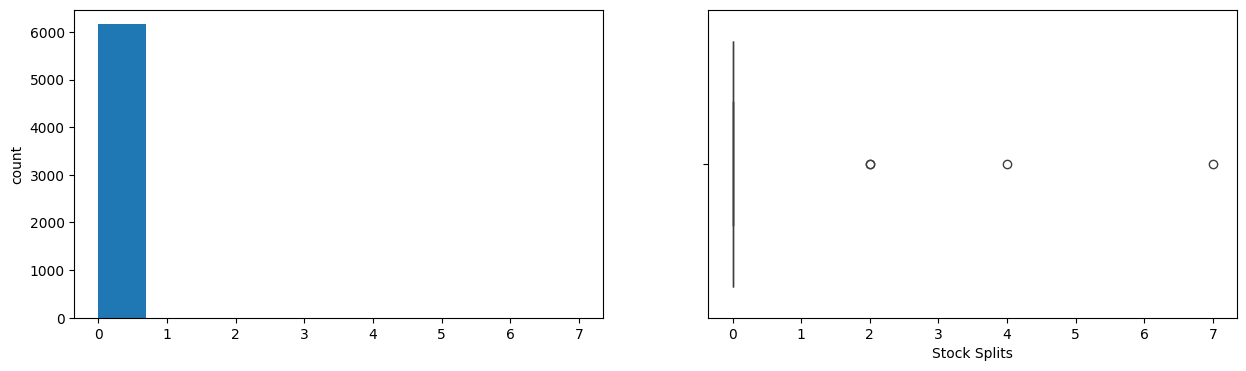

In [59]:
import seaborn as sns

for col in num_cols:
    print(col)
    print('Skew :', round(prices_df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    prices_df[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=prices_df[col])
    plt.show()


## Existe asimetria en los datos
## Los Dividendos estan altamente cesgados hacia la derecha al igual que los Stock Splits

In [60]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6165 entries, 2000-01-03 to 2024-07-05
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6165 non-null   float64
 1   High          6165 non-null   float64
 2   Low           6165 non-null   float64
 3   Close         6165 non-null   float64
 4   Volume        6165 non-null   int64  
 5   Dividends     6165 non-null   float64
 6   Stock Splits  6165 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 514.4+ KB


# transformando datos cesgados
## aplicando una transformacion logaritmica para normalizar los datos

In [61]:
def log_transform(data,col):
    for colname in col:
        if (data[colname] == 1.0).all():
            data[colname + '_log'] = np.log(data[colname]+1)
        else:
            data[colname + '_log'] = np.log(data[colname])
    data.info()

Text(0, 0.5, 'Precio de Cierre')

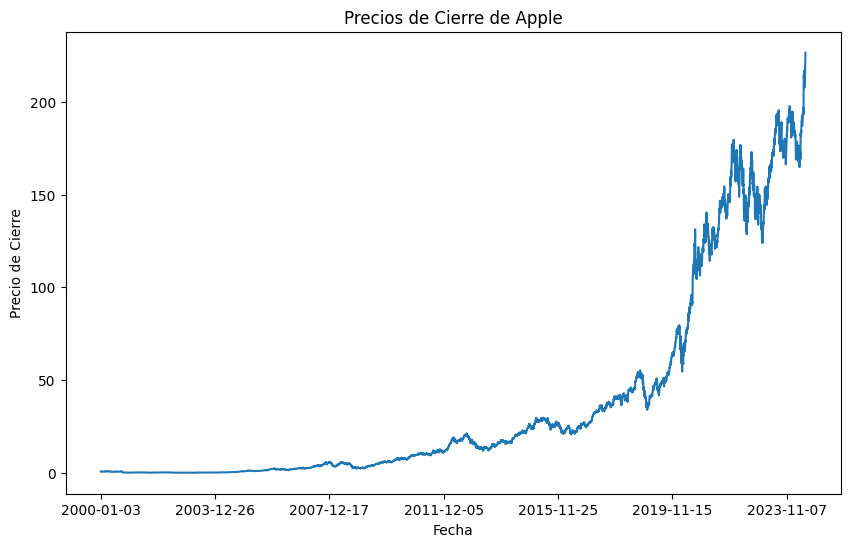

In [62]:
# Imprimir los precios de Cierre
fig, ax = plt.subplots(figsize=(10, 6))
prices_df['Close'].plot(ax=ax)
ax.set_title('Precios de Cierre de Apple')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio de Cierre')

# Analisis Bivariable de los datos

### Utilizando un grafico de pares para ver relaciones entre las diferentes variables


#### En general la relacion entre las variables es lineal , notando no linealidades sobretodo en variables relacionadas con el volumen de las operaciones

<Figure size 1300x1700 with 0 Axes>

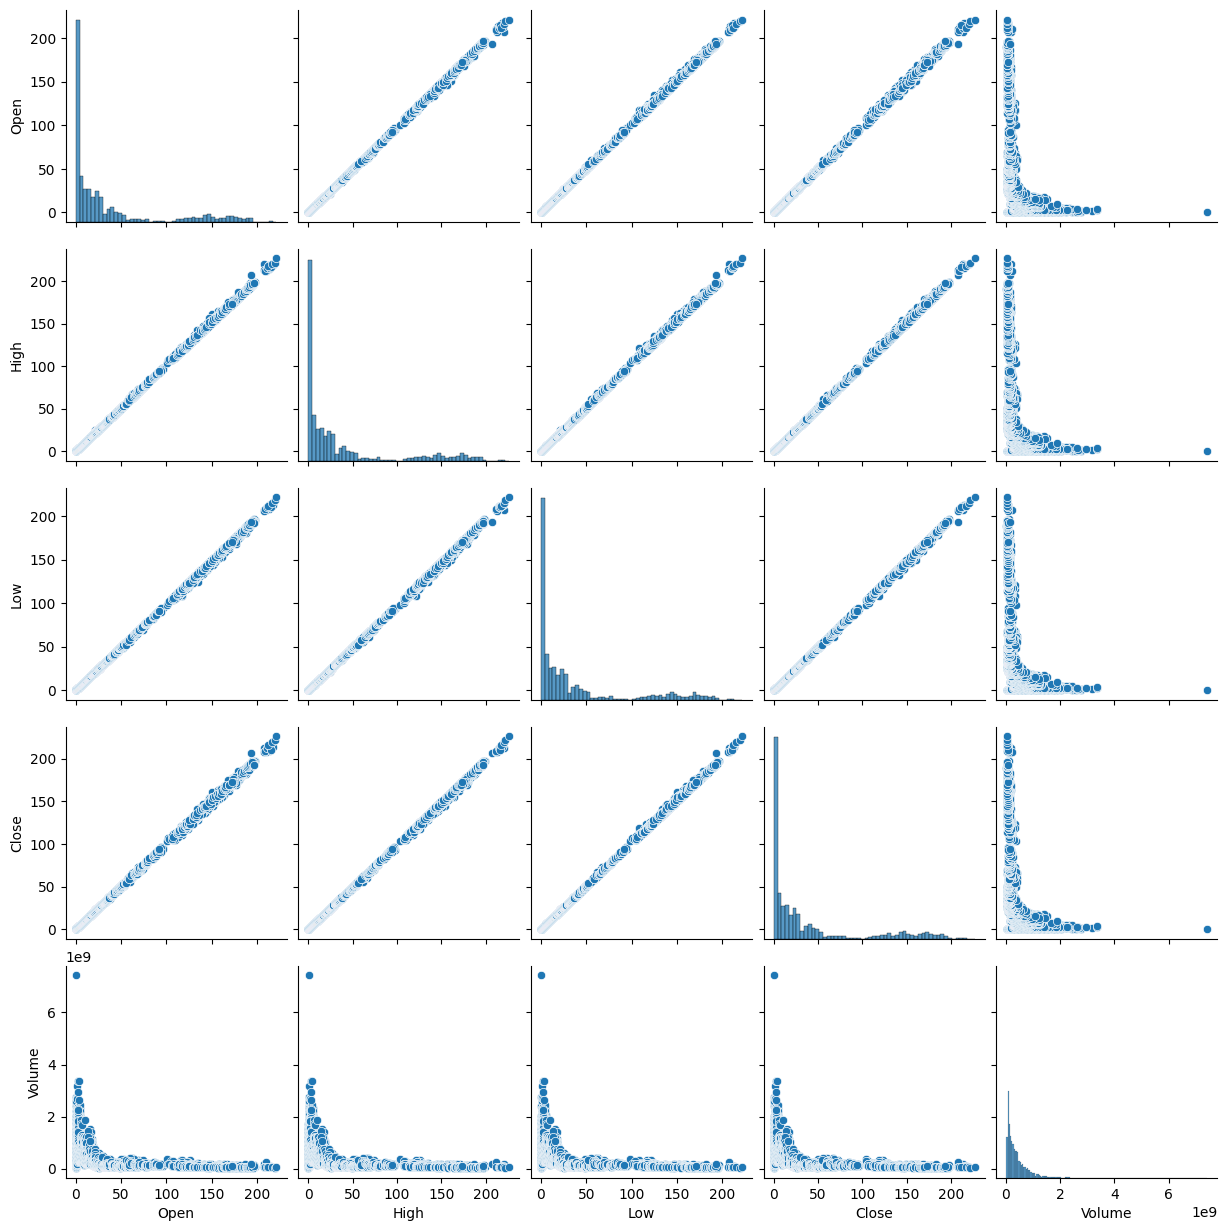

In [63]:
plt.figure(figsize=(13,17))
sns.pairplot(data=prices_df.drop(['Dividends', 'Stock Splits'],axis=1))
plt.show()

# Analizando Correlación entre los datos usando un mapa de calor

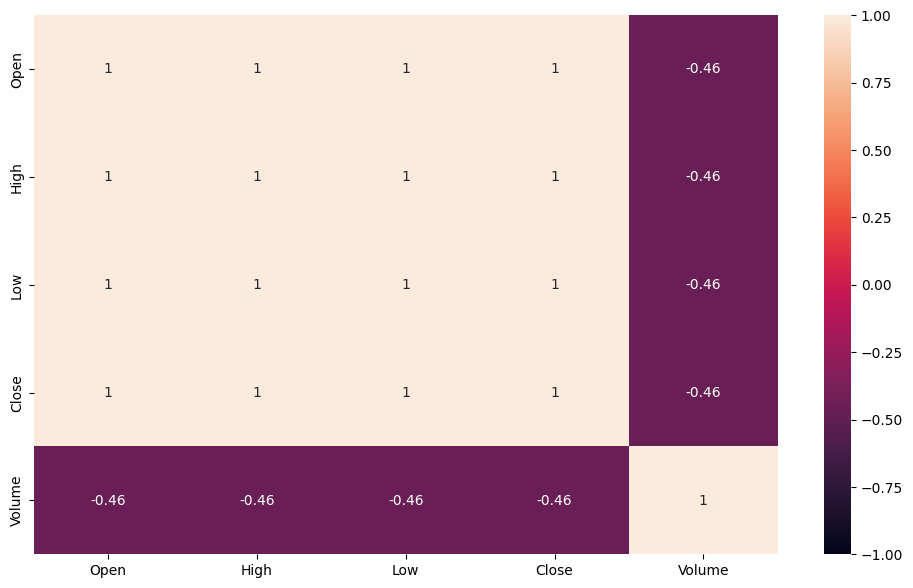

In [64]:
plt.figure(figsize=(12, 7))
sns.heatmap(prices_df.drop(['Dividends','Stock Splits'],axis=1).corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

## Hay una correlación negativa entre el volumen y el resto de variables

Analizando columna: Open
Outliers usando IQR en Open:
                  Open        High         Low       Close     Volume
Date                                                                 
2020-07-31  100.479055  103.926505   98.467223  103.775131  374336800
2020-08-03  105.669758  109.026873  105.369454  106.390015  308151200
2020-08-04  106.580446  108.199186  105.852865  107.100494  173071600
2020-08-05  106.819745  107.811009  106.350966  107.488724  121776800
2020-08-06  107.823205  111.736990  107.229913  111.238914  202428800
...                ...         ...         ...         ...        ...
2024-06-28  215.770004  216.070007  210.300003  210.619995   82542700
2024-07-01  212.089996  217.509995  211.919998  216.750000   60402900
2024-07-02  216.149994  220.380005  215.100006  220.270004   58046200
2024-07-03  220.000000  221.550003  219.029999  221.550003   37369800
2024-07-05  221.649994  226.449997  221.649994  226.339996   58797569

[988 rows x 5 columns]


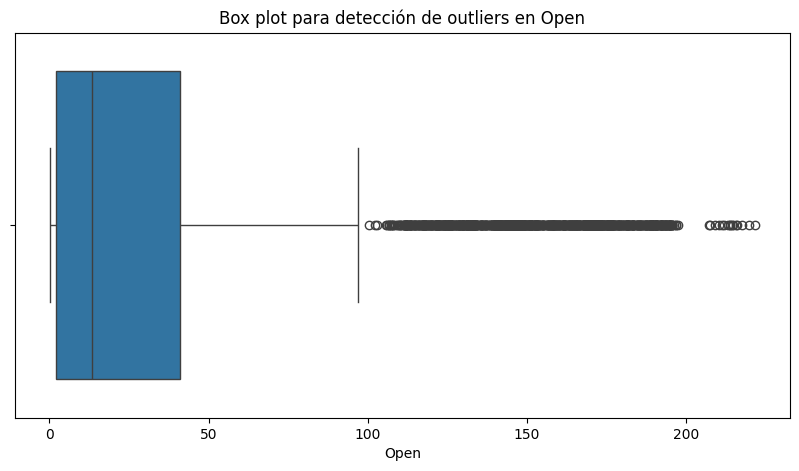

Outliers usando z-score en Open:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.100006   49772700
2024-06-28  215.770004  216.070007  210.300003  210.61999

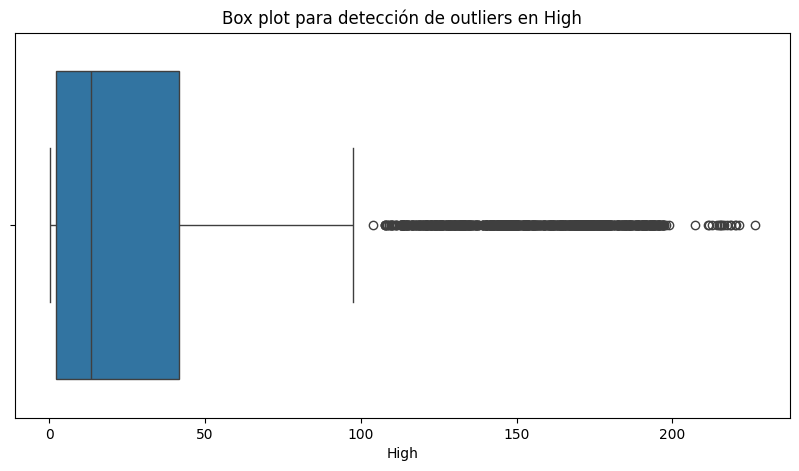

Outliers usando z-score en High:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-11  193.649994  207.160004  193.630005  207.149994  172373300
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.10000

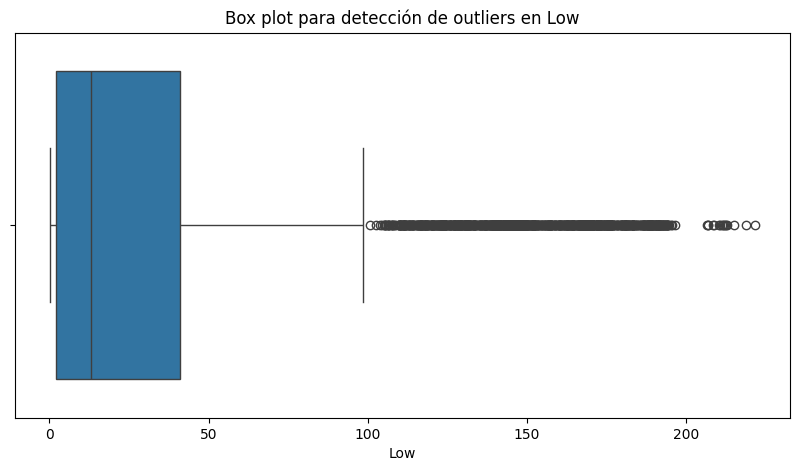

Outliers usando z-score en Low:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.100006   49772700
2024-06-28  215.770004  216.070007  210.300003  210.619995

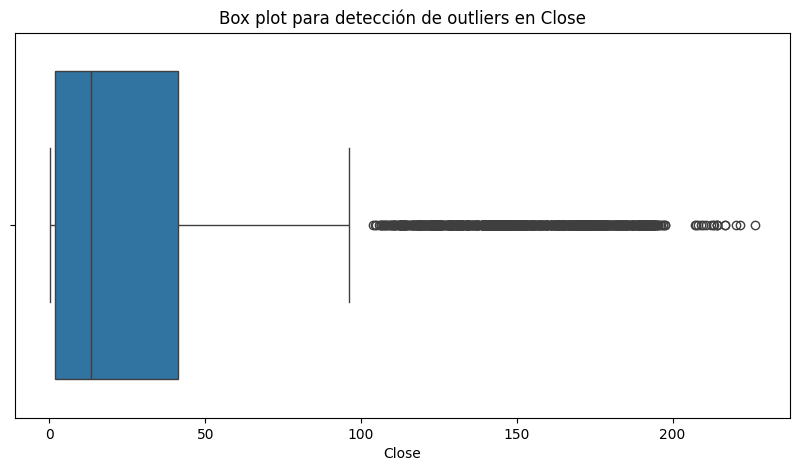

Outliers usando z-score en Close:
                  Open        High         Low       Close     Volume
Date                                                                 
2024-06-11  193.649994  207.160004  193.630005  207.149994  172373300
2024-06-12  207.369995  220.199997  206.899994  213.070007  198134300
2024-06-13  214.740005  216.750000  211.600006  214.240005   97862700
2024-06-14  213.850006  215.169998  211.300003  212.490005   70122700
2024-06-17  213.369995  218.949997  212.720001  216.669998   93728300
2024-06-18  217.589996  218.630005  213.000000  214.289993   79943300
2024-06-20  213.929993  214.240005  208.850006  209.679993   86172500
2024-06-21  210.389999  211.889999  207.110001  207.490005  246421400
2024-06-24  207.720001  212.699997  206.589996  208.139999   80727000
2024-06-25  209.149994  211.380005  208.610001  209.070007   56713900
2024-06-26  211.500000  214.860001  210.639999  213.250000   66213200
2024-06-27  214.690002  215.740005  212.350006  214.1000

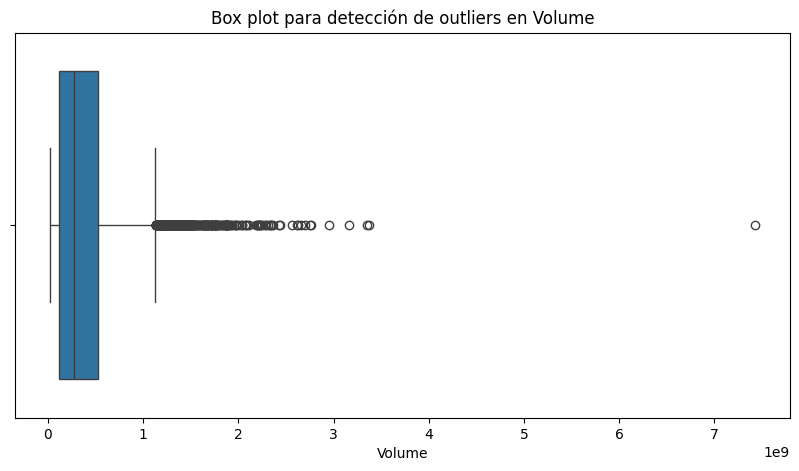

Outliers usando z-score en Volume:
                Open       High       Low      Close      Volume
Date                                                            
2000-01-20  0.871873   0.917165  0.856776   0.856776  1831132800
2000-09-29  0.425557   0.437824  0.383096   0.388757  7421640800
2000-10-02  0.402912   0.403855  0.354788   0.366112  2424788800
2000-10-03  0.376491   0.377435  0.334973   0.336861  2038120000
2001-04-19  0.385738   0.388757  0.356298   0.388305  1873670400
...              ...        ...       ...        ...         ...
2009-01-15  2.432790   2.539982  2.417089   2.517637  1831634000
2010-01-26  6.218606   6.452917  6.116850   6.218304  1867110000
2010-01-27  6.245783   6.358409  6.024757   6.276884  1722568400
2010-05-07  7.358761   7.445117  6.800157   7.121731  1676018400
2011-01-18  9.949771  10.409939  9.843485  10.285838  1880998000

[109 rows x 5 columns]
Outliers usando percentiles en Volume:
                  Open        High         Low       Clos

In [65]:

from scipy import stats
# Excluir las columnas 'Dividends' y 'Stock Splits'
df_filtered = prices_df.drop(columns=['Dividends', 'Stock Splits'])

# Seleccionar solo las columnas numéricas
num_cols = df_filtered.select_dtypes(include=np.number).columns.tolist()

# Función para detectar outliers usando diferentes métodos
def detect_outliers(df, columns):
    for col in columns:
        print(f"Analizando columna: {col}")

        # Método del rango intercuartílico (IQR)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"Outliers usando IQR en {col}:")
        print(outliers_iqr)

        # Visualización con un diagrama de caja
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[col])
        plt.title(f'Box plot para detección de outliers en {col}')
        plt.show()

        # Análisis de z-score
        z_scores = np.abs(stats.zscore(df[col]))
        outliers_zscore = df[z_scores > 3]

        print(f"Outliers usando z-score en {col}:")
        print(outliers_zscore)

        # Método de percentiles
        lower_percentile = df[col].quantile(0.01)
        upper_percentile = df[col].quantile(0.99)
        outliers_percentile = df[(df[col] < lower_percentile) | (df[col] > upper_percentile)]

        print(f"Outliers usando percentiles en {col}:")
        print(outliers_percentile)

# Detectar outliers en las columnas numéricas excluyendo 'Dividends' y 'Stock Splits'
detect_outliers(df_filtered, num_cols)

### Creación del modelo

## Existe Presencia de otliers , pero no representan un problema dada la natural;e